In [3]:
import utility as ut
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [4]:
def load_matrices(filename="matrices.npz"):
    """
    Loads P and Phi matrices from a .npz file.

    Parameters:
    - filename: The filename to load (default: "matrices.npz").

    Returns:
    - P: Loaded storage function matrix.
    - Phi: Loaded supply rate function matrix.
    """
    data = np.load(filename)
    P = data["P"]
    Phi = data["Phi"]
    print(f"Loaded matrices from {filename}")
    return P, Phi

In [5]:
P, Phi = load_matrices(filename="matrices.npz")

Loaded matrices from matrices.npz


In [6]:
print(P.shape)
print(Phi.shape)

(25, 25)
(25, 25)


In [7]:
# Load data
DIRECTORY = "data/"
datasets = ut.load_excel_data(DIRECTORY)

In [8]:
DURATION = 15  # duration in seconds
DT = 0.02  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)

In [9]:
interpolated_datasets = []
for i in range(len(datasets)):
    new_trolley_position = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position"]
    )
    new_cable_length = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length"]
    )
    new_sway_angle = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["sway_angle"]
    )
    new_trolley_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_trolley_motor"]
    )
    new_hoist_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_hoist_motor"]
    )
    interpolated_df = {
        "trolley_position": new_trolley_position,
        "cable_length": new_cable_length,
        "sway_angle": new_sway_angle,
        "trolley_motor_pwm": new_trolley_motor_pwm,
        "hoist_motor_pwm": new_hoist_motor_pwm,
    }

    interpolated_datasets.append(interpolated_df)

print(len(interpolated_datasets))


39


In [10]:
def dissipativity_inequality(P, Phi, xi0, xi1, Z):
    """
    Computes the dissipativity inequality for fault detection.

    Parameters:
    - P: Storage function matrix.
    - Phi: Supply rate function matrix.
    - xi0: Column vector for xi(k).
    - xi1: Column vector for xi(k+1).
    - Z: Column vector for Z(k).

    Returns:
    - True if the dissipativity inequality is satisfied, False otherwise.
    """
    # Compute the left-hand side of the inequality
    lhs = xi1.T @ P @ xi1 - xi0.T @ P @ xi0

    # Compute the right-hand side of the inequality
    rhs = Z.T @ Z

    # Check if the inequality is satisfied
    return lhs - rhs

In [11]:
L = 5  # Number of past steps to include
N = 5  # Number of future steps to predict
T = NUM_STEPS # Number of time steps
num_inputs = 2  # Number of inputs
num_outputs = 3  # Number of outputs

TF = 10 # window of samples observed for detecting faults

In [12]:
xi_list = []
zeta_list = []
Y_array = []
J_array = []
Y_square_array = []

for data in interpolated_datasets:
    for k in range (L, T - N):
        k -= 1
        past_outputs = np.column_stack([data["trolley_position"][k-L:k], data["cable_length"][k-L:k], data["sway_angle"][k-L:k]])
        past_inputs = np.column_stack([data["trolley_motor_pwm"][k-L:k], data["hoist_motor_pwm"][k-L:k]])

        xi = np.column_stack([past_outputs, past_inputs]).reshape(-1, 1)
        xi_list.append(xi)

        future_outputs = np.column_stack([data["trolley_position"][k:k+N], data["cable_length"][k:k+N], data["sway_angle"][k:k+N]])
        future_inputs = np.column_stack([data["trolley_motor_pwm"][k:k+N], data["hoist_motor_pwm"][k:k+N]])

        zeta = np.column_stack([future_outputs, future_inputs]).reshape(-1, 1)
        zeta_list.append(zeta)

        if k > L:
            Y = dissipativity_inequality(P, Phi, xi_list[k-L], xi_list[k-L+1], zeta_list[k-L])
            Y_array.append(Y)
            Y_square_array.append(Y_array[k-L-1]**2)

            if len(Y_square_array) > TF:
                J_array.append(np.sqrt(np.sum(Y_square_array[k-TF-L:k-L])))


In [13]:
# Calculate the mean of the fault detection metric
J_mean = np.mean(J_array)
print(f"Mean of the fault detection metric: {J_mean}")

# Calculate the standard deviation of the fault detection metric
J_std = np.std(J_array)
print(f"Standard deviation of the fault detection metric: {J_std}")

# Determine the threshold for fault detection
threshold = J_mean + 3 * J_std
print(f"Threshold for fault detection: {threshold}")

Mean of the fault detection metric: 2084302.7884169323
Standard deviation of the fault detection metric: 3712279.0396891045
Threshold for fault detection: 13221139.907484245


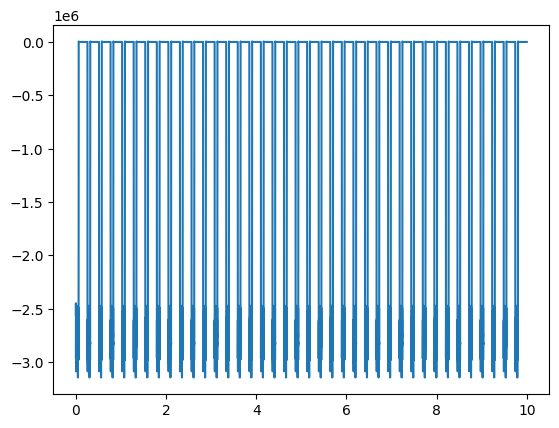

In [14]:
plt.plot(np.linspace(0, 10, len(Y_array)), np.array(Y_array).flatten())

In [17]:
print(Y_array)

[array([[-2557621.71909508]]), array([[-2448946.10316861]]), array([[-2657795.9378908]]), array([[-2676928.55651358]]), array([[-2965824.62562368]]), array([[-2825876.39070351]]), array([[-2824640.46100848]]), array([[-2789386.41825376]]), array([[-2754073.77088743]]), array([[-2694021.31290463]]), array([[-2604167.31822628]]), array([[-2729772.2059109]]), array([[-2934724.90088797]]), array([[-3087666.09278835]]), array([[-2917169.83535729]]), array([[-2961609.35466528]]), array([[-2843832.99181874]]), array([[-2713766.23675661]]), array([[-2620170.65280394]]), array([[-2654904.43846711]]), array([[-2844973.28457741]]), array([[-2759955.96971705]]), array([[-2861760.20281732]]), array([[-2804870.63406019]]), array([[-2978873.20206103]]), array([[-2941342.7447792]]), array([[-2762926.48469355]]), array([[-2709776.37367908]]), array([[-2691608.53113296]]), array([[-2824808.25794361]]), array([[-2737327.97551977]]), array([[-2733738.3620559]]), array([[-2872729.26531198]]), array([[-2911

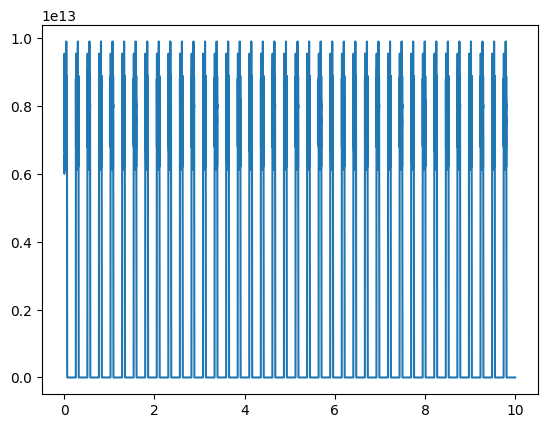

In [15]:
plt.plot(np.linspace(0, 10, len(Y_square_array)), np.array(Y_square_array).flatten())

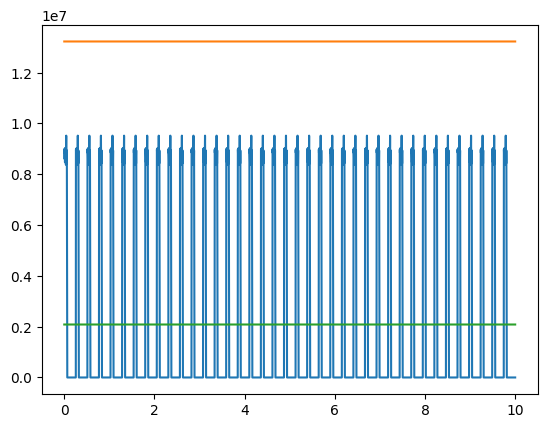

In [16]:
plt.plot(np.linspace(0, 10, len(J_array)), np.array(J_array).flatten())
plt.plot(np.linspace(0, 10, len(J_array)), np.linspace(threshold, threshold, len(J_array)))
plt.plot(np.linspace(0, 10, len(J_array)), np.linspace(J_mean, J_mean, len(J_array)))